In [ ]:
!pip install torch torchvision torchaudio

!pip install timm

!pip install numpy scikit-learn matplotlib Pillow tqdm

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image

import timm 
from torch.optim import AdamW 
from torch.optim.lr_scheduler import CosineAnnealingLR 
import torch.nn.functional as F 

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm 
import pandas as pd
import seaborn as sns


DATA_ROOT = '/kaggle/input/asl-alphabet-dataset' 
TRAIN_DIR = os.path.join(DATA_ROOT, 'asl_alphabet_train/asl_alphabet_train') 
TEST_DIR = os.path.join(DATA_ROOT, 'asl_alphabet_test/asl_alphabet_test') 
NUM_CLASSES = 29 
IMG_SIZE = 224
BATCH_SIZE = 80
LR = 2e-5 
NUM_EPOCHS = 6
SEED = 42

VAL_SPLIT_RATIO = 0.10 
MODEL_SAVE_PATH = '/kaggle/working/best_asl_fusion_model.pth'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
np.random.seed(SEED)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
class AlphabetDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

class FusionASLModel(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.6):
        super(FusionASLModel, self).__init__()
        
        # --- PATH 1: CNN Backbone (EfficientNetB5) ---
        self.cnn_backbone = timm.create_model('efficientnet_b5', pretrained=True, num_classes=0) 
        
        # --- PATH 2: ViT Backbone (ViT-Base/Patch16) ---
        self.vit_backbone = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)

        # 1. Freeze ALL layers first
        for param in self.cnn_backbone.parameters():
            param.requires_grad = False
        for param in self.vit_backbone.parameters():
            param.requires_grad = False
        
        # 2. Unfreeze LAST 2 blocks of CNN (EffNetB5)
        for block in self.cnn_backbone.blocks[-2:]:
            for param in block.parameters():
                param.requires_grad = True

        # 3. Unfreeze LAST 2 blocks of ViT
        for block in self.vit_backbone.blocks[-2:]:
            for param in block.parameters():
                param.requires_grad = True

        # --- Fusion Classifier Head ---
        CNN_FEAT_DIM = self.cnn_backbone.num_features 
        VIT_FEAT_DIM = self.vit_backbone.num_features 
        TOTAL_FUSION_DIM = CNN_FEAT_DIM + VIT_FEAT_DIM 
        
        self.fusion_classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(TOTAL_FUSION_DIM, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_features = self.cnn_backbone(x)
        vit_features = self.vit_backbone(x)
        
        fused_features = torch.cat((cnn_features, vit_features), dim=1)
        output = self.fusion_classifier(fused_features)
        return output


model = FusionASLModel(num_classes=NUM_CLASSES, dropout_rate=0.6).to(DEVICE) 
print(f"Dual-Backbone Fusion Model loaded to {DEVICE}.")

Dual-Backbone Fusion Model loaded to cuda.


In [ ]:
NORMALIZE = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5), 
    transforms.ToTensor(),
    NORMALIZE,
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.2), ratio=(0.3, 3.3), value='random')
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    NORMALIZE
])

train_val_filepaths = []
train_val_labels = []

CLASS_NAMES_FULL = sorted(os.listdir(TRAIN_DIR))
CLASS_NAMES = [c for c in CLASS_NAMES_FULL if os.path.isdir(os.path.join(TRAIN_DIR, c))]
CLASS_TO_INDEX = {name: i for i, name in enumerate(CLASS_NAMES)}

for class_name in CLASS_NAMES:
    class_path = os.path.join(TRAIN_DIR, class_name)
    for filename in os.listdir(class_path):
        file_path = os.path.join(class_path, filename)
        if os.path.isfile(file_path): 
            try:
                with Image.open(file_path) as img:
                    img.verify()
                train_val_filepaths.append(file_path)
                train_val_labels.append(CLASS_TO_INDEX[class_name])
            except:
                continue

train_files, val_files, train_labels, val_labels = train_test_split(
    train_val_filepaths, train_val_labels, 
    test_size=VAL_SPLIT_RATIO, 
    stratify=train_val_labels, 
    random_state=SEED
)

test_filepaths = []
test_labels = []

for class_index, class_name in enumerate(CLASS_NAMES):
    class_test_path = os.path.join(TEST_DIR, class_name) 
    
    if os.path.isdir(class_test_path):
         for filename in os.listdir(class_test_path):
            file_path = os.path.join(class_test_path, filename)
            if os.path.isfile(file_path): 
                test_filepaths.append(file_path)
                test_labels.append(class_index)

train_dataset = AlphabetDataset(train_files, train_labels, transform=train_transform)
val_dataset = AlphabetDataset(val_files, val_labels, transform=val_test_transform)
test_dataset = AlphabetDataset(test_filepaths, test_labels, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=1) 

print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")

Train samples: 78300
Validation samples: 8700



--- Starting Model Training ---


Epoch 1/6 (Training, LR=0.000020):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 1/6:
Train    | Loss: 1.9273 | Acc: 0.4464 | Prec: 0.4529 | Rec: 0.4464 | F1: 0.4469
Validation | Loss: 0.0777 | Acc: 0.9878 | Prec: 0.9886 | Rec: 0.9878 | F1: 0.9878
*** Validation F1 improved to 0.9878. Model saved to /kaggle/working/best_asl_fusion_model.pth ***


Epoch 2/6 (Training, LR=0.000019):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 2/6:
Train    | Loss: 0.2366 | Acc: 0.9380 | Prec: 0.9380 | Rec: 0.9380 | F1: 0.9380
Validation | Loss: 0.0018 | Acc: 0.9999 | Prec: 0.9999 | Rec: 0.9999 | F1: 0.9999
*** Validation F1 improved to 0.9999. Model saved to /kaggle/working/best_asl_fusion_model.pth ***


Epoch 3/6 (Training, LR=0.000015):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 3/6:
Train    | Loss: 0.1190 | Acc: 0.9693 | Prec: 0.9694 | Rec: 0.9693 | F1: 0.9693
Validation | Loss: 0.0005 | Acc: 0.9999 | Prec: 0.9999 | Rec: 0.9999 | F1: 0.9999


Epoch 4/6 (Training, LR=0.000010):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 4/6:
Train    | Loss: 0.0855 | Acc: 0.9775 | Prec: 0.9775 | Rec: 0.9775 | F1: 0.9775
Validation | Loss: 0.0003 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000
*** Validation F1 improved to 1.0000. Model saved to /kaggle/working/best_asl_fusion_model.pth ***


Epoch 5/6 (Training, LR=0.000005):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 5/6:
Train    | Loss: 0.0740 | Acc: 0.9803 | Prec: 0.9804 | Rec: 0.9803 | F1: 0.9803
Validation | Loss: 0.0002 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000


Epoch 6/6 (Training, LR=0.000001):   0%|          | 0/979 [00:00<?, ?it/s]


Epoch 6/6:
Train    | Loss: 0.0701 | Acc: 0.9816 | Prec: 0.9817 | Rec: 0.9816 | F1: 0.9816
Validation | Loss: 0.0001 | Acc: 1.0000 | Prec: 1.0000 | Rec: 1.0000 | F1: 1.0000

--- Training Complete ---

--- Visualizing Training Performance before Final Test ---


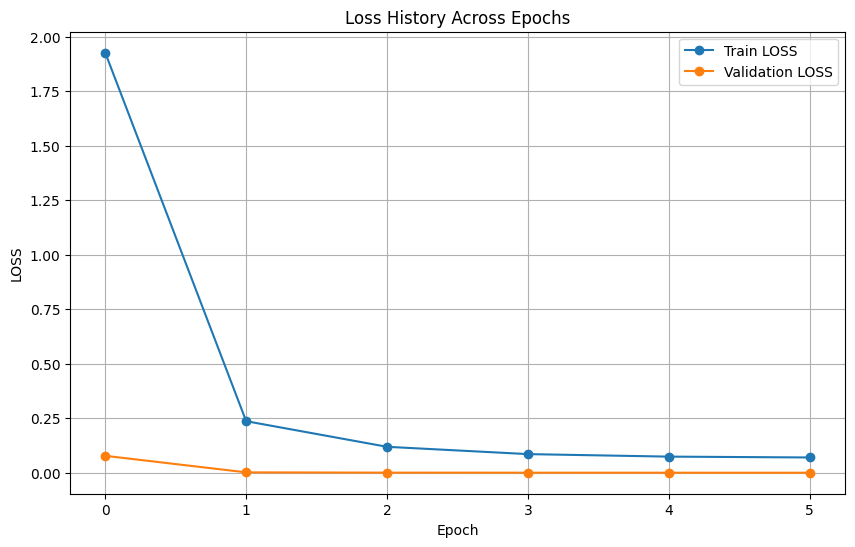

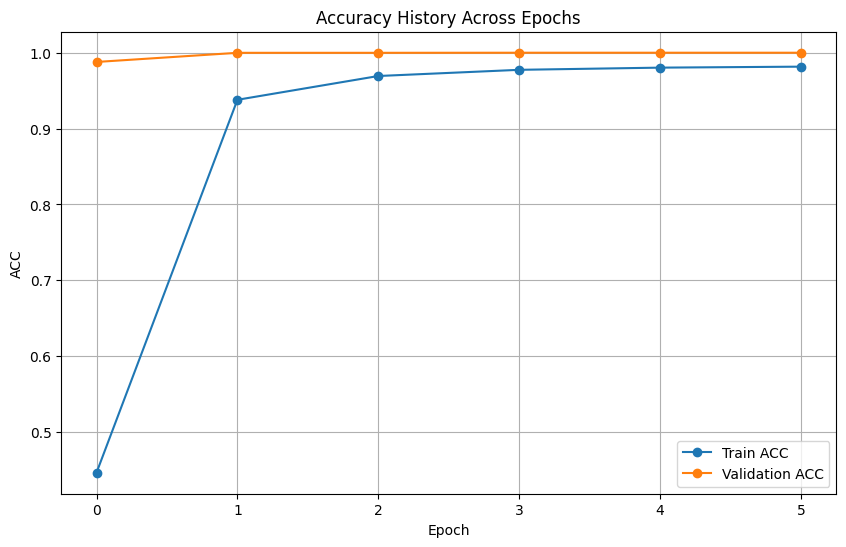

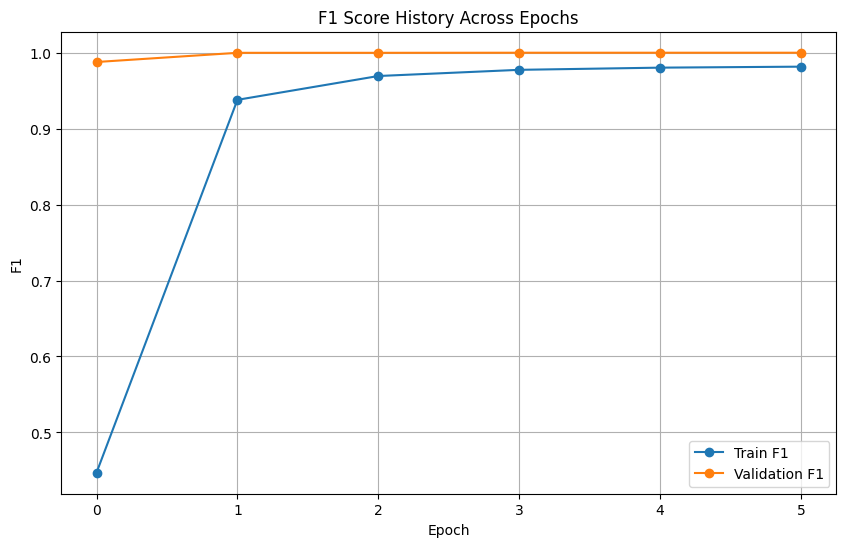

In [ ]:
def evaluate_metrics(model, dataloader, criterion, name):
    model.eval()
    all_preds = []
    all_targets = []
    running_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    avg_loss = running_loss / len(dataloader.dataset)

    accuracy = accuracy_score(all_targets, all_preds)
    precision, recall, f1, _ = precision_score(all_targets, all_preds, average='macro', zero_division=0), \
                               recall_score(all_targets, all_preds, average='macro', zero_division=0), \
                               f1_score(all_targets, all_preds, average='macro', zero_division=0), \
                               None

    return avg_loss, {'acc': accuracy, 'prec': precision, 'rec': recall, 'f1': f1}, all_targets, all_preds


# --- Training Setup ---
criterion = nn.CrossEntropyLoss().to(DEVICE) 
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=1e-4) 
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS) 
best_val_f1 = 0.0

history = {
    'train_loss': [], 'val_loss': [],
    'train_acc': [], 'val_acc': [],
    'train_f1': [], 'val_f1': []
}

# --- Training Loop ---
print("\n--- Starting Model Training ---")

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    train_preds_epoch, train_targets_epoch = [], [] 
    
    current_lr = optimizer.param_groups[0]['lr']
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{NUM_EPOCHS} (Training, LR={current_lr:.6f})")
    
    for batch_idx, (inputs, targets) in pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)

        with torch.no_grad():
            _, preds = torch.max(outputs, 1)
            train_preds_epoch.extend(preds.cpu().numpy())
            train_targets_epoch.extend(targets.cpu().numpy())
        
        pbar.set_postfix({'Batch Loss': f'{loss.item():.4f}'}) 

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = accuracy_score(train_targets_epoch, train_preds_epoch)
    train_f1 = f1_score(train_targets_epoch, train_preds_epoch, average='macro', zero_division=0)

    val_loss, val_metrics, _, _ = evaluate_metrics(model, val_loader, criterion, "Validation")

    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
    print(f"Train    | Loss: {train_loss:.4f} | Acc: {train_accuracy:.4f} | Prec: {precision_score(train_targets_epoch, train_preds_epoch, average='macro', zero_division=0):.4f} | Rec: {recall_score(train_targets_epoch, train_preds_epoch, average='macro', zero_division=0):.4f} | F1: {train_f1:.4f}")
    print(f"Validation | Loss: {val_loss:.4f} | Acc: {val_metrics['acc']:.4f} | Prec: {val_metrics['prec']:.4f} | Rec: {val_metrics['rec']:.4f} | F1: {val_metrics['f1']:.4f}")

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_accuracy)
    history['val_acc'].append(val_metrics['acc'])
    history['train_f1'].append(train_f1)
    history['val_f1'].append(val_metrics['f1'])

    val_f1 = val_metrics['f1']
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), MODEL_SAVE_PATH) 
        print(f"*** Validation F1 improved to {best_val_f1:.4f}. Model saved to {MODEL_SAVE_PATH} ***")

    scheduler.step()

print("\n--- Training Complete ---")

print("\n--- Visualizing Training Performance before Final Test ---")

def plot_metric_history(history, metric, title):
    """Plots training and validation history for a given metric."""
    plt.figure(figsize=(10, 6))
    plt.plot(history[f'train_{metric}'], label=f'Train {metric.upper()}', marker='o')
    plt.plot(history[f'val_{metric}'], label=f'Validation {metric.upper()}', marker='o')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(metric.upper())
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metric_history(history, 'loss', 'Loss History Across Epochs')
plot_metric_history(history, 'acc', 'Accuracy History Across Epochs')
plot_metric_history(history, 'f1', 'F1 Score History Across Epochs')

Best model weights loaded successfully from /kaggle/working/best_asl_fusion_model.pth.

--- Visualizing Training Performance ---

--- FINAL TEST SET RESULTS ---
Final Test Accuracy: 1.0000
Final Test F1 Score (Macro): 1.0000

--- Detailed Classification Report (TEST Set) ---
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.

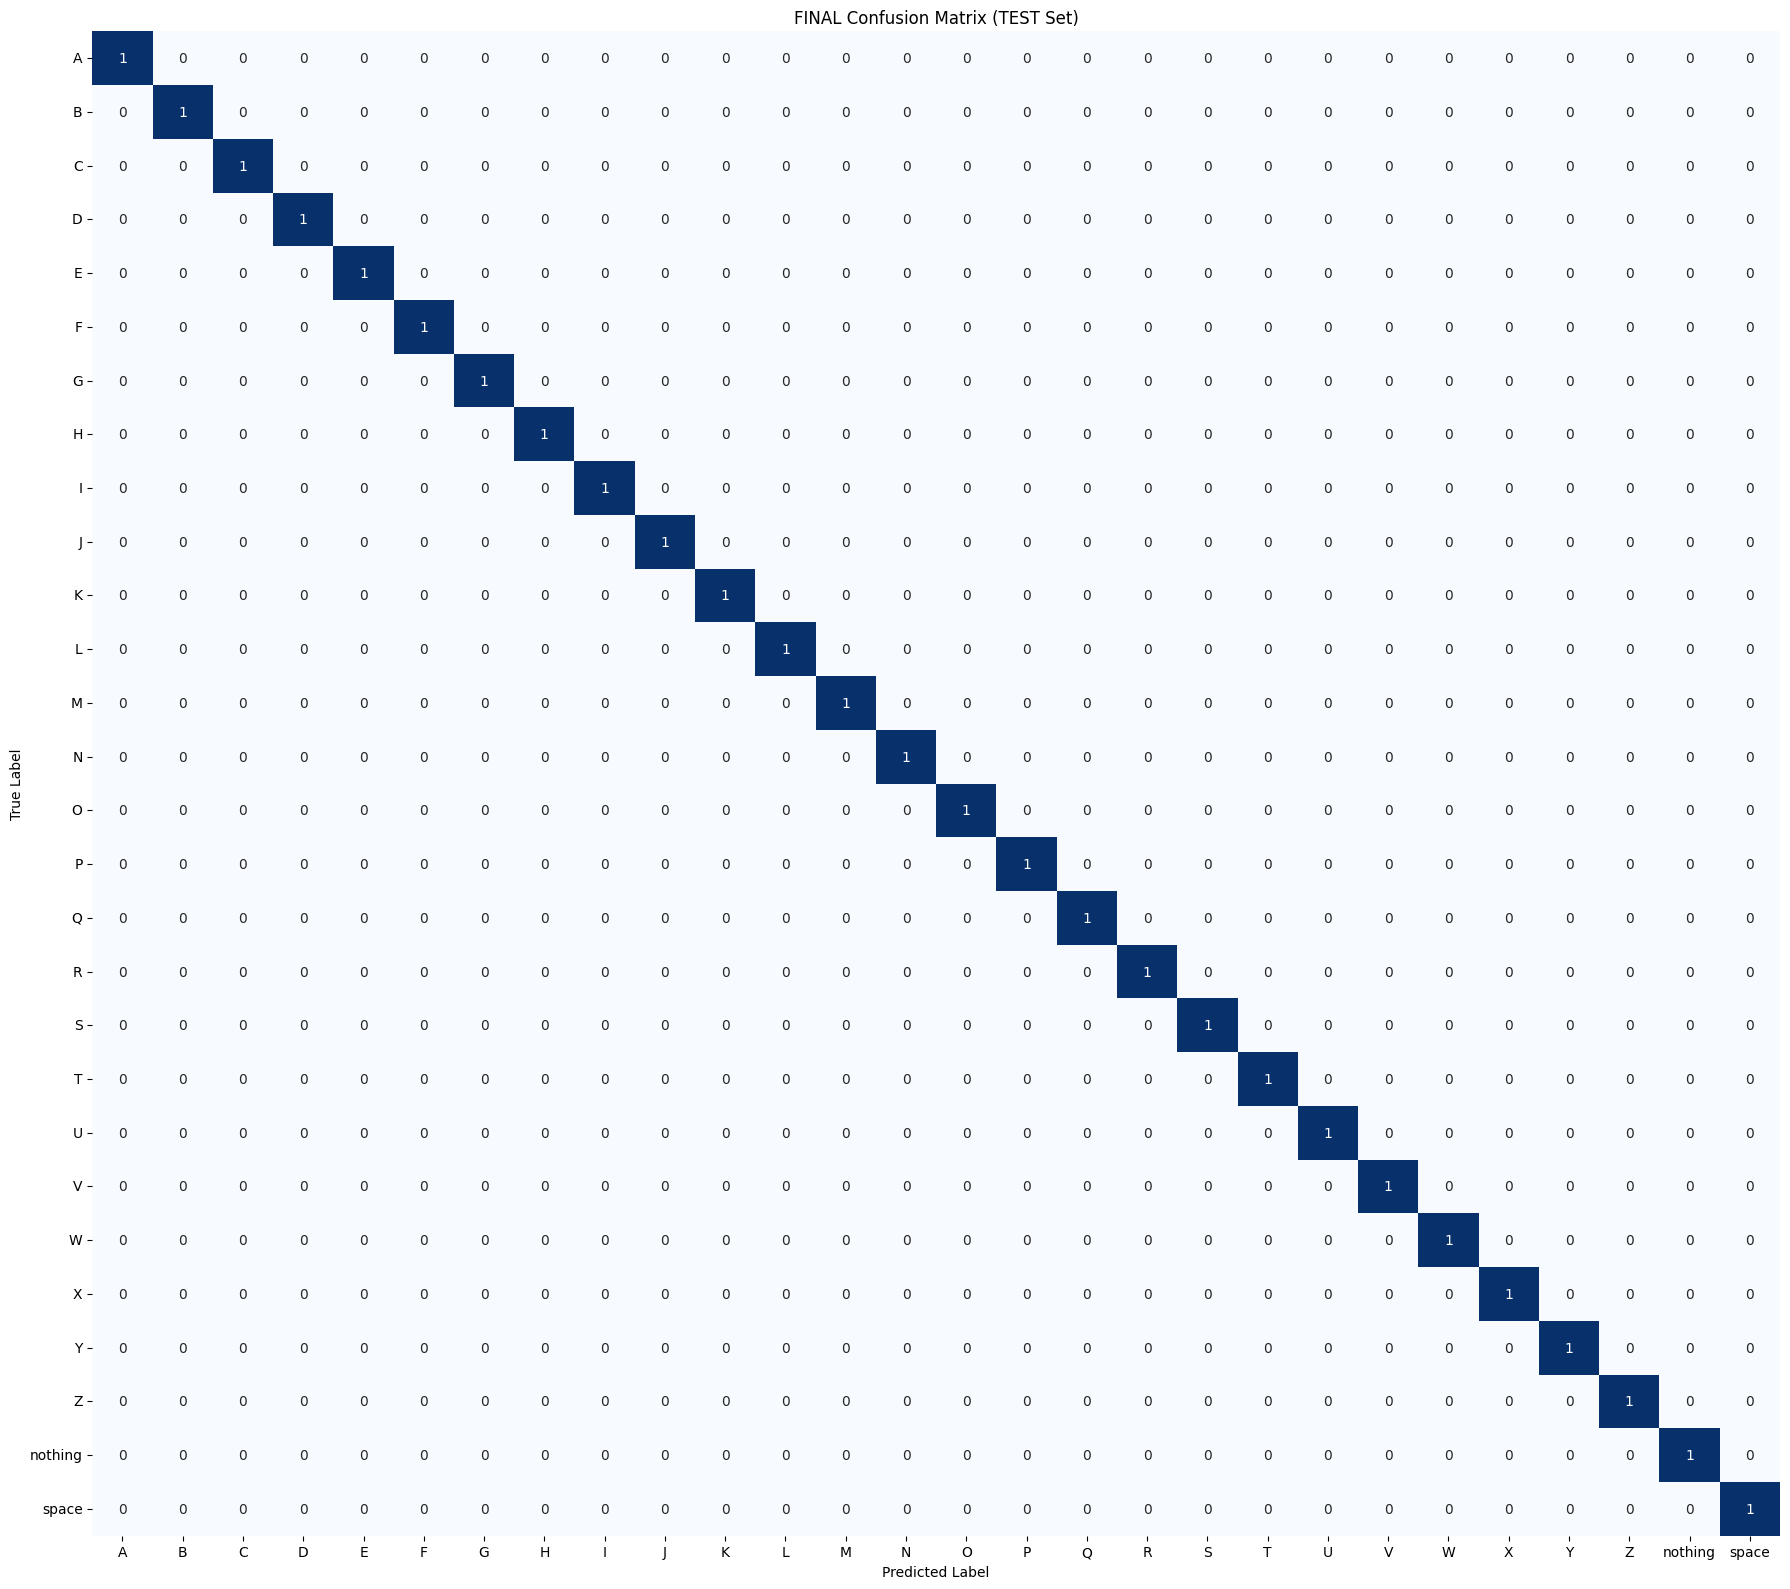


--- Visual Inspection of Test Images ---


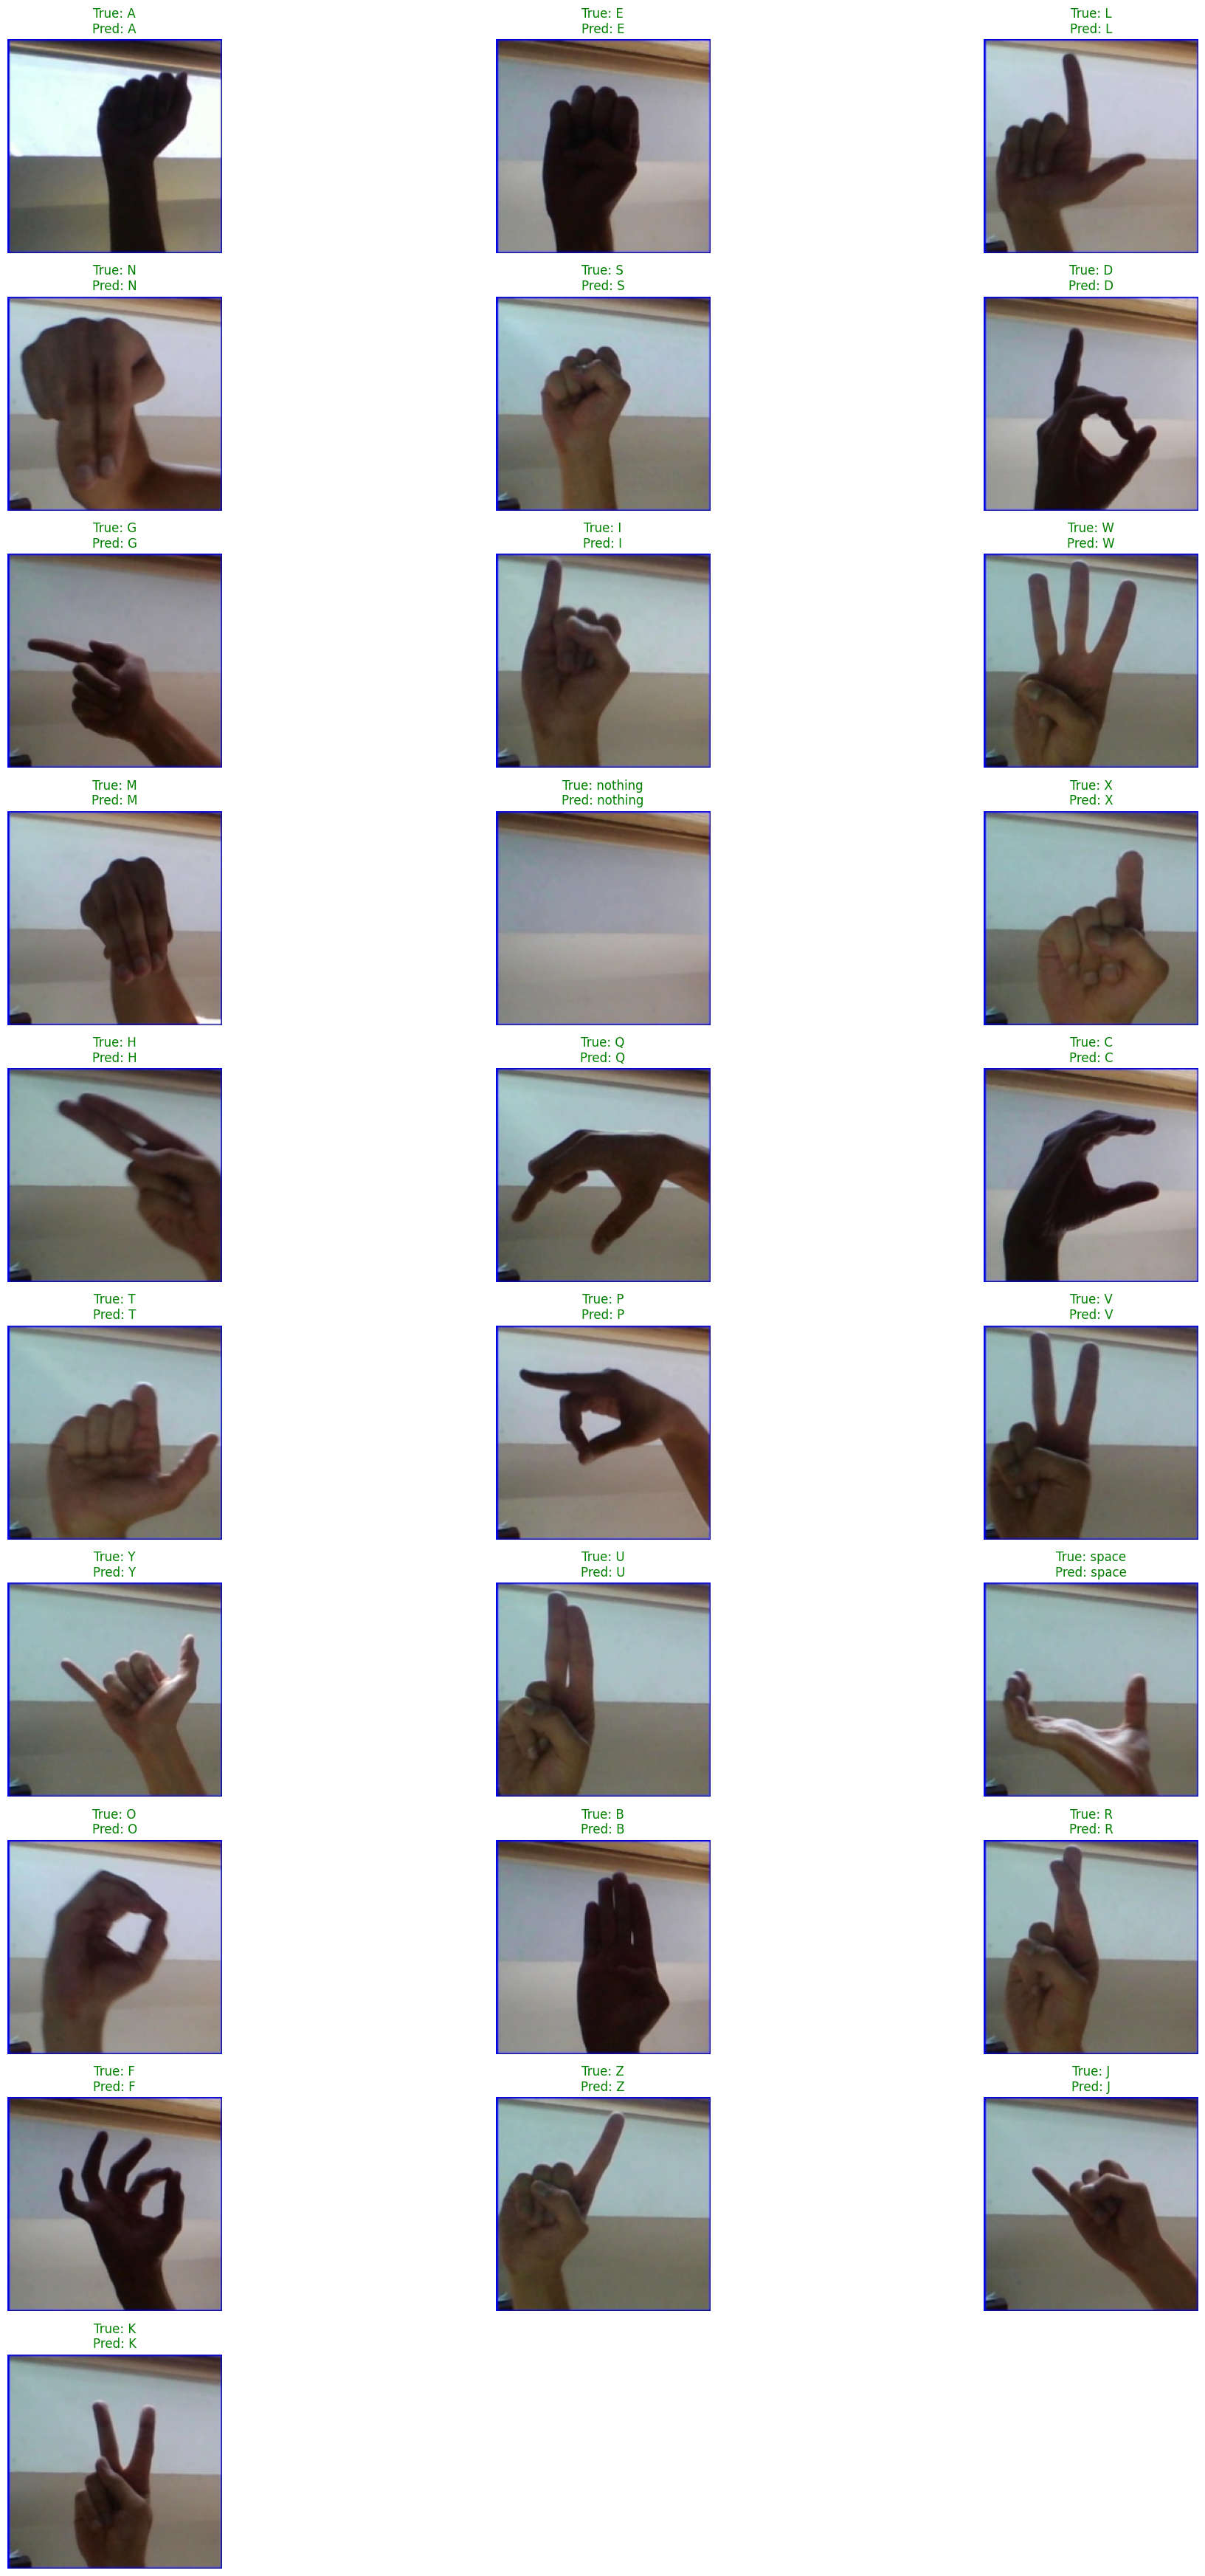

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from torch.optim import AdamW 
from torch.nn import functional as F 

try:
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f"Best model weights loaded successfully from {MODEL_SAVE_PATH}.")
except FileNotFoundError:
    print(f"Error: Best model file not found at {MODEL_SAVE_PATH}. Cannot perform final inference.")
    raise

model.eval()
test_criterion = nn.CrossEntropyLoss().to(DEVICE)

test_loss, test_metrics, test_targets_final, test_preds_final = evaluate_metrics(model, test_loader, test_criterion, "TEST SET")

try:
    DEL_INDEX = CLASS_NAMES.index('del')
except ValueError:
    DEL_INDEX = -1 

INDICES_TO_REPORT = np.arange(NUM_CLASSES)

TARGET_CLASS_NAMES = [name for name in CLASS_NAMES if name != 'del']


def plot_confusion_matrix(y_true, y_pred, labels):

    INDICES_FOR_CM = INDICES_TO_REPORT[INDICES_TO_REPORT != DEL_INDEX] 

    cm = confusion_matrix(y_true, y_pred, labels=INDICES_FOR_CM) 
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    
    plt.figure(figsize=(18, 16)) 
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('FINAL Confusion Matrix (TEST Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_individual_predictions(dataloader, y_true, y_pred, class_names):
    idx_to_class = {i: c for i, c in enumerate(class_names)}
    plt.figure(figsize=(20, 35)) 
    test_loader_iter = iter(dataloader)
    
    for i in range(len(y_true)):
        try:
            inputs, _ = next(test_loader_iter)
        except StopIteration:
            break
        
        img_tensor = inputs[0].cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_unnormalized = torch.clamp(img_tensor * std + mean, 0, 1)
        
        img_display = img_unnormalized.permute(1, 2, 0).numpy()
        
        true_label = idx_to_class[y_true[i]]
        pred_label = idx_to_class[y_pred[i]]
        
        color = 'green' if true_label == pred_label else 'red'
        
        plt.subplot(10, 3, i + 1)
        plt.imshow(img_display)
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=12)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


print("\n--- Visualizing Training Performance ---")

print("\n--- FINAL TEST SET RESULTS ---")

print(f"Final Test Accuracy: {test_metrics['acc']:.4f}")
print(f"Final Test F1 Score (Macro): {test_metrics['f1']:.4f}") 

print("\n--- Detailed Classification Report (TEST Set) ---")
report_str = classification_report(
    y_true=test_targets_final, 
    y_pred=test_preds_final, 
    target_names=CLASS_NAMES, 
    labels=np.arange(NUM_CLASSES), 
    zero_division=0
)

lines = report_str.split('\n')
output_lines = []
custom_message = "NOT AVAILABLE IN THE TEST DATASET"
replacement_row = f"         del {custom_message.rjust(71)}" 

for line in lines:
    line_stripped = line.strip()

    if line_stripped.startswith('del') and '0.00' in line_stripped and '0' in line_stripped.split()[-1]:
        output_lines.append(replacement_row)
    elif line_stripped.startswith('macro avg'):
        continue 
    else:
        output_lines.append(line)

print('\n'.join(output_lines))

plot_confusion_matrix(test_targets_final, test_preds_final, TARGET_CLASS_NAMES)

print("\n--- Visual Inspection of Test Images ---")
plot_individual_predictions(test_loader, test_targets_final, test_preds_final, CLASS_NAMES)